# Sujet 7 : Autour du SARS-CoV-2 (Covid-19)


## Analyse rapide des donnees recuperees
Imports des packages necessaires a l'analyse

In [1]:
## import
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
import datetime
import os.path
from urllib.request import urlretrieve


Pour cette analyse, nous utiliserons les données compilées par le Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE) mises à disposition sur GitHub, plus particulièrement les données __time_series_covid19_confirmed_global.csv__

Ces donnees sont disponibles aussi à l'adresse : https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv.

Nous commencons par verifier la presence d'une copie des donnees. Si elle n'existe pas, nous allons la recuperer sur le site et creons la copie locale.


In [2]:
data_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"   
data_local = "time_series_covid19_confirmed_global.csv"
if not os.path.isfile(data_local):
    urlretrieve(data_url, data_local)

### 1ere visualisation des donnees : 
Comptage rapide du nombre de donnees presentes :


In [3]:
raw_data = pd.read_csv(data_local)
raw_data.shape

(289, 1147)

Le fichier contient 289 lignes pour 1147 colonnes

On regarde le formattage des donnees a savoir 
* chaque pays/province est indiquee en ligne 
* les donnees des colonnes 1 a 4 correspondent aux infos du pays/region converne
* les donnees des colonnes 5 et suivantes correspondent aux nombres de cas cummule par jour (jour indique en etiquette de la colonne)

In [4]:
raw_data

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
259                                           NaN                  Tuvalu   
260                                           NaN                      US   
261                                           NaN                  Uganda   
262                                           NaN                 Ukraine   
263                                           NaN    United Arab Emirates   
264                                      Anguilla          United Kingdom   
265                                       Bermuda          United Kingdom   
266                        British Virgin Islands          United Kingdom   
267                                Cayman Islands          United Kingdom   
268                               Channel Islands          United Kingdom   
269                   Falkland Islands (Malvinas)          United Kingdom   
270                                     Gibraltar          United Kingdom   
271                                      Guernsey          United Kingdom   
272                                   Isle of Man          United Kingdom   
273                                        Jersey          United Kingdom   
274                                    Montserrat          United Kingdom   
275                              Pitcairn Islands          United Kingdom   
276  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
277                      Turks and Caicos Islands          United Kingdom   
278                                           NaN          United Kingdom   
279                            


### Verification rapide de l'integrite des donnes

#### Verification d'absence de donnees ou de donnees negatives
On regarde ici si on a une colonne de donnees (colonne 5 et suivante) dont le comptage serait negatif.


In [5]:
columns_to_study =  raw_data.iloc[:,4:].columns

for i in raw_data.index :    
    for d in range(len(columns_to_study[:-1])):
        if (pd.isna(raw_data.iloc[i,d+4]) or raw_data.iloc[i,d+4]<0):
            print(raw_data.iloc[i,d+4])

--> aucun retour donc aucune valeur manquante ou negative

#### Est-ce qu'il y a des donnees qui sont superieures a celle du jour suivant ?
On peut aussi regarder si chaque valeur est inferieure a la valeur suivante.

In [6]:
flag = 0
for i in raw_data.index :  
    for d in range(len(columns_to_study[:-1])):
        if (int(raw_data.iloc[i,d+4]) > int(raw_data.iloc[i,d+4 +1])):
            data_problem = (raw_data.iloc[i, 1:2], columns_to_study[d], columns_to_study[d+1])
            flag = flag +1
print("Il y a %s donnees superieurs a celle de la donnee suivante" % str(flag))

Il y a 362 donnees superieurs a celle de la donnee suivante


--> il y a donc bien des valeurs possiblement incoherentes avec des jours ou le taux cummule de cas decroit par rapport a la veille. 
Est-ce une rectification due a un mauvais diagnostique initial ? une modification de la methode de comptage ?

Aux vues du faible nombre d'incoherence (362) par rapport au nombre de donnees total (288 lignes de donnees * 1142 comptage = 328896 donnees totales), on peut choisir de passer outre et de conserver la table ainsi



## 1eres analyses realisees uniquement sur la France

On commence par ne recuperer que la ligne de donnees correspondant a la France 

--> Country/Region = France ET Province/State = Nan

In [7]:
df_france = raw_data.loc[(raw_data['Country/Region'] == "France")  & (raw_data['Province/State'].isnull())]
df_france

Province/State Country/Region      Lat    Long  1/22/20  1/23/20  1/24/20  \
131            NaN         France  46.2276  2.2137        0        0        2   

     1/25/20  1/26/20  1/27/20    ...      2/28/23    3/1/23    3/2/23  \
131        3        3        3    ...     38579269  38583794  38587990   

       3/3/23    3/4/23    3/5/23    3/6/23    3/7/23    3/8/23    3/9/23  
131  38591184  38591184  38591184  38599330  38606393  38612201  38618509  

[1 rows x 1147 columns]

Pour le plot, on transpose les donnees en ne conservant que les lignes des incidences cummulees - a partir de la colonne 5 

In [8]:
df_france_final = df_france.transpose()[5:]



Pour plus de clarte on change le nom de la colonne pour le nom du pays France

In [9]:
df_france_final.rename(columns={131: "France"}, inplace=True)
df_france_final.head()

France
1/23/20      0
1/24/20      2
1/25/20      3
1/26/20      3
1/27/20      3

On change les dates en un format interpretable par pandas

In [10]:
all_dates = pd.to_datetime(df_france_final.index)
all_dates

DatetimeIndex(['2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26',
               '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
               '2020-01-31', '2020-02-01',
               ...
               '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03',
               '2023-03-04', '2023-03-05', '2023-03-06', '2023-03-07',
               '2023-03-08', '2023-03-09'],
              dtype='datetime64[ns]', length=1142, freq=None)

On reinitialise ces dates formattees comme index de la table de donnees 

In [11]:
df_france_final.index = all_dates
df_france_final.head()

France
2020-01-23      0
2020-01-24      2
2020-01-25      3
2020-01-26      3
2020-01-27      3

On peut ploter l'incidence en France 

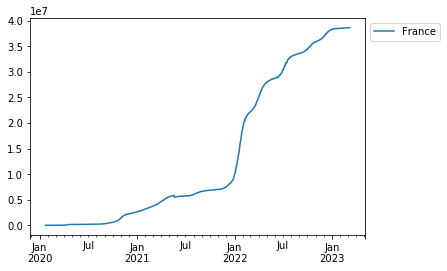

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
df_france_final.plot(ax=ax)
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

## Generalisation aux pays d'interet que sont :

* la Belgique (Belgium)
* la Chine - toutes les provinces sauf Hong-Kong (China)
* Hong Kong (China, Hong-Kong)
* la France métropolitaine (France)
* l’Allemagne (Germany)
* l’Iran (Iran)
* l’Italie (Italy)
* le Japon (Japan)
* la Corée du Sud (Korea, South)
* la Hollande sans les colonies (Netherlands)
* le Portugal (Portugal)
* l’Espagne (Spain)
* le Royaume-Unis sans les colonies (United Kingdom)
* les États-Unis (US).


### Creation d'un pays "Hong-Kong" 
Hong-Kong apparait comme une province de la Chine. Pour plus de facilite a recupere les donnees, nous remplacons le pays anciennement "China" par Hong Kong pour la province Hong Kong uniquement. 
Je choisis de faire une copie du fichier initial raw_data pour pouvoir y revenir le cas echeant. 


In [13]:
new_data= raw_data
new_data.loc[(new_data['Province/State'] == "Hong Kong"),'Country/Region'] = "Hong Kong"
new_data.loc[(new_data['Province/State'] == "Hong Kong"),'Province/State'] = np.nan
new_data.loc[(new_data['Country/Region'] == "Hong Kong")]

Province/State Country/Region   Lat   Long  1/22/20  1/23/20  1/24/20  \
71            NaN      Hong Kong  22.3  114.2        0        2        2   

    1/25/20  1/26/20  1/27/20   ...     2/28/23   3/1/23   3/2/23   3/3/23  \
71        5        8        8   ...     2876106  2876106  2876106  2876106   

     3/4/23   3/5/23   3/6/23   3/7/23   3/8/23   3/9/23  
71  2876106  2876106  2876106  2876106  2876106  2876106  

[1 rows x 1147 columns]

### Gestion particuliere de la Chine
La Chine apparait sous de multiples province que nous allons sommer en un unique pays.

On commence par recuperer toutes les donnees de Chine


In [14]:
df_china = new_data.loc[(new_data['Country/Region'] == "China")]
df_china


Province/State Country/Region      Lat      Long  1/22/20  1/23/20  \
59           Anhui          China  31.8257  117.2264        1        9   
60         Beijing          China  40.1824  116.4142       14       22   
61       Chongqing          China  30.0572  107.8740        6        9   
62          Fujian          China  26.0789  117.9874        1        5   
63           Gansu          China  35.7518  104.2861        0        2   
64       Guangdong          China  23.3417  113.4244       26       32   
65         Guangxi          China  23.8298  108.7881        2        5   
66         Guizhou          China  26.8154  106.8748        1        3   
67          Hainan          China  19.1959  109.7453        4        5   
68           Hebei          China  39.5490  116.1306        1        1   
69    Heilongjiang          China  47.8620  127.7615        0        2   
70           Henan          China  37.8957  114.9042        5        5   
72           Hubei          China  30.9756  112.2707      444      444   
73           Hunan          China  27.6104  111.7088        4        9   
74  Inner Mongolia          China  44.0935  113.9448        0        0   
75         Jiangsu          China  32.9711  119.4550        1        5   
76         Jiangxi          China  27.6140  115.7221        2        7   
77           Jilin          China  43.6661  126.1923        0        1   
78        Liaoning          China  41.2956  122.6085        2        3   
79           Macau          China  22.1667  113.5500        1        2   
80         Ningxia          China  37.2692  106.1655        1        1   
81         Qinghai          China  35.7452   95.9956        0        0   
82         Shaanxi          China  35.1917  108.8701        0        3   
83        Shandong          China  36.3427  118.1498        2        6   
84        Shanghai          China  31.2020  121.4491        9       16   
85          Shanxi          China  37.5777  112.2922        1        1   
86         Sichuan          China  30.6171  102.7103        5        8   
87         Tianjin          China  39.3054  117.3230        4        4   
88           Tibet          China  31.6927   88.0924        0        0   
89         Unknown          China      NaN       NaN        0        0   
90        Xinjiang          China  41.1129   85.2401        0        2   
91          Yunnan          China  24.9740  101.4870        1        2   
92        Zhejiang          China  29.1832  120.0934       10       27   

    1/24/20  1/25/20  1/26/20  1/27/20   ...     2/28/23   3/1/23   3/2/23  \
59       15       39       60       70   ...        2275     2275     2275   
60       36       41       68       80   ...       40774    40774    40774   
61       27       57       75      110   ...       14715    14715    14715   
62       10       18       35       59   ...       17122    17122    17122   
63        2        4        7       14   ...        1742     1742     1742   
64       53       78      111      151   ...      103248   103248   103248   
65       23       23       36       46   ...       13371    13371    13371   
66        3        4        5        7   ...        2534     2534     2534   
67        8       19       22       33   ...       10483    10483    10483   
68        2        8       13       18   ...        3292     3292     3292   
69        4        9       15       21   ...        6603     6603     6603   
70        9       32       83      128   ...        9948     9948     9948   
72      549      761     1058     1423   ...       72131    72131    72131   
73       24       43       69      100   ...        7437     7437     7437   
74        1        7        7       11   ...        8847     8847     8847   
75        9       18       33       47   ...        5075     5075     5075   
76       18       18       36       72   ...        3423     3423     3423   
77        3        4        4        6   ...       40764    40764    40764   
78   

On somme toutes les donnes et on reinitialise les province, lattitude, longitude a NA, le pays a China.

On travaille sur une Serie pandas, on la reformate en dataframe avec une tranposition. 

In [15]:
df_China_combined = df_china.sum()
df_China_combined["Province/State"] = np.nan
df_China_combined["Lat"] = np.nan
df_China_combined["Long"] = np.nan
df_China_combined["Country/Region"] = "China"
df_China_combined = pd.DataFrame(df_China_combined)
df_China_combined = df_China_combined.transpose()
df_China_combined

Province/State Country/Region  Lat Long 1/22/20 1/23/20 1/24/20 1/25/20  \
0            NaN          China  NaN  NaN     548     641     918    1401   

  1/26/20 1/27/20   ...     2/28/23   3/1/23   3/2/23   3/3/23   3/4/23  \
0    2067    2869   ...     2027418  2027418  2027418  2027418  2027418   

    3/5/23   3/6/23   3/7/23   3/8/23   3/9/23  
0  2027418  2027418  2027418  2027418  2027418  

[1 rows x 1147 columns]

On ajoute les donnees China "total" dans un nouveau dataframe pandas "newSet"


In [16]:
newSet = pd.concat([new_data,df_China_combined])
newSet.loc[(newSet['Country/Region'] == "China")]

Province/State Country/Region      Lat      Long 1/22/20 1/23/20 1/24/20  \
59           Anhui          China  31.8257  117.2264       1       9      15   
60         Beijing          China  40.1824  116.4142      14      22      36   
61       Chongqing          China  30.0572  107.8740       6       9      27   
62          Fujian          China  26.0789  117.9874       1       5      10   
63           Gansu          China  35.7518  104.2861       0       2       2   
64       Guangdong          China  23.3417  113.4244      26      32      53   
65         Guangxi          China  23.8298  108.7881       2       5      23   
66         Guizhou          China  26.8154  106.8748       1       3       3   
67          Hainan          China  19.1959  109.7453       4       5       8   
68           Hebei          China  39.5490  116.1306       1       1       2   
69    Heilongjiang          China  47.8620  127.7615       0       2       4   
70           Henan          China  37.8957  114.9042       5       5       9   
72           Hubei          China  30.9756  112.2707     444     444     549   
73           Hunan          China  27.6104  111.7088       4       9      24   
74  Inner Mongolia          China  44.0935  113.9448       0       0       1   
75         Jiangsu          China  32.9711  119.4550       1       5       9   
76         Jiangxi          China  27.6140  115.7221       2       7      18   
77           Jilin          China  43.6661  126.1923       0       1       3   
78        Liaoning          China  41.2956  122.6085       2       3       4   
79           Macau          China  22.1667  113.5500       1       2       2   
80         Ningxia          China  37.2692  106.1655       1       1       2   
81         Qinghai          China  35.7452   95.9956       0       0       0   
82         Shaanxi          China  35.1917  108.8701       0       3       5   
83        Shandong          China  36.3427  118.1498       2       6      15   
84        Shanghai          China  31.2020  121.4491       9      16      20   
85          Shanxi          China  37.5777  112.2922       1       1       1   
86         Sichuan          China  30.6171  102.7103       5       8      15   
87         Tianjin          China  39.3054  117.3230       4       4       8   
88           Tibet          China  31.6927   88.0924       0       0       0   
89         Unknown          China      NaN       NaN       0       0       0   
90        Xinjiang          China  41.1129   85.2401       0       2       2   
91          Yunnan          China  24.9740  101.4870       1       2       5   
92        Zhejiang          China  29.1832  120.0934      10      27      43   
0              NaN          China      NaN       NaN     548     641     918   

   1/25/20 1/26/20 1/27/20   ...     2/28/23   3/1/23   3/2/23   3/3/23  \
59      39      60      70   ...        2275     2275     2275     2275   
60      41      68      80   ...       40774    40774    40774    40774   
61      57      75     110   ...       14715    14715    14715    14715   
62      18      35      59   ...       17122    17122    17122    17122   
63       4       7      14   ...        1742     1742     1742     1742   
64      78     111     151   ...      103248   103248   103248   103248   
65      23      36      46   ...       13371    13371    13371    13371   
66       4       5       7   ...        2534     2534     2534     2534   
67      19      22      33   ...       10483    10483    10483    10483   
68       8      13      18   ...        3292     3292     3292     3292   
69       9      15      21   ...        6603     6603     6603     6603   
70      32      83     128   ...        9948     9948     9948     9948   
72     761    1058    1423   ...       72131    72131    72131    72131   
73      43      69     100   ...        7437     7437     7437     7437   
74       7       7      11   ...        8847     8847     8847     8847   
75 

### Recuperation des donnees pour les pays d'interet listes ci dessus

On cree une liste avec les pays d'interet "interest_countries".

On recupere par la suite un sous jeu de donnees avec uniquement ces pays et "NA" en province. 

In [17]:
interest_countries = ["Belgium", "China", "France", "Germany", "Hong Kong", "Iran", "Italy", "Japan", "Korea, South", "Netherlands", "Portugal", "Spain", "United Kingdom", "US"]
df_allCountries = newSet.loc[(newSet['Country/Region'].isin(interest_countries)) & (newSet['Province/State'].isnull())  ,]
df_allCountries


Province/State  Country/Region        Lat        Long 1/22/20 1/23/20  \
24             NaN         Belgium  50.833300    4.469936       0       0   
71             NaN       Hong Kong  22.300000  114.200000       0       2   
131            NaN          France  46.227600    2.213700       0       0   
135            NaN         Germany  51.165691   10.451526       0       0   
150            NaN            Iran  32.427908   53.688046       0       0   
154            NaN           Italy  41.871940   12.567380       0       0   
156            NaN           Japan  36.204824  138.252924       2       2   
162            NaN    Korea, South  35.907757  127.766922       1       1   
200            NaN     Netherlands  52.132600    5.291300       0       0   
218            NaN        Portugal  39.399900   -8.224500       0       0   
241            NaN           Spain  40.463667   -3.749220       0       0   
260            NaN              US  40.000000 -100.000000       1       1   
278            NaN  United Kingdom  55.378100   -3.436000       0       0   
0              NaN           China        NaN         NaN     548     641   

    1/24/20 1/25/20 1/26/20 1/27/20    ...        2/28/23     3/1/23  \
24        0       0       0       0    ...        4717655    4717655   
71        2       5       8       8    ...        2876106    2876106   
131       2       3       3       3    ...       38579269   38583794   
135       0       0       0       1    ...       38168908   38189954   
150       0       0       0       0    ...        7567906    7568903   
154       0       0       0       0    ...       25576852   25576852   
156       2       2       4       4    ...       33227230   33241180   
162       2       2       3       4    ...       30526012   30533573   
200       0       0       0       0    ...        8596157    8596157   
218       0       0       0       0    ...        5566708    5568084   
241       0       0       0       0    ...       13763336   13763336   
260       2       2       5       5    ...      103443455  103533872   
278       0       0       0       0    ...       24370150   24370150   
0       918    1401    2067    2869    ...        2027418    2027418   

        3/2/23     3/3/23     3/4/23     3/5/23     3/6/23     3/7/23  \
24     4727795    4727795    4727795    4727795    4727795    4727795   
71     2876106    2876106    2876106    2876106    2876106    2876106   
131   38587990   38591184   38591184   38591184   38599330   38606393   
135   38202571   38210850   38210850   38210851   38210851   38231610   
150    7569261    7569483    7569769    7570232    7570743    7571352   
154   25576852   25603510   25603510   25603510   25603510   25603510   
156   33252686   33263208   33273639   33282370   33286633   33298799   
162   30543981   30555102   30555102   30569215   30581499   30594297   
200    8596157    8598043    8598043    8598043    8598043    8599981   
218    5568084    5568084    5568084    5568084    5568084    5568084   
241   13763336   13770429   13770429   13770429   13770429   13770429   
260  103589757  103648690  103650837  103646975  103655539  103690910   
278   24396530   24396530   24396530   24396530   24396530   24396530   
0      2027418    2027418    2027418    2027418    2027418    2027418   

        3/8/23     3/9/23  
24     4727795    4739365  
71     2876106    2876106  
131   38612201   38618509  
135   38241231   38249060  
150    7571996    7572311  
154   25603510   25603510  
156   33310604   33320438  
162   30605187   30615522  
200    8599981    8599981  
218    5570473    5570473  
241   13770429   13770429  
260  103755771  103802702  
278   24396530   24425309  
0      2027418    2027418  

[14 rows x 1147 columns]

### Analyse de l'évolution du nombre de cas cumulés au cours du temps

On transforma la table pour etre plus comprehensible par matplotlib pour faire le graphique - globalement on realise une transposition en supprimant les data lattitude/longitude pour le moment et en renommant les colonnes avec le nom du pays correspondant.


In [18]:
df_allCountries_final = df_allCountries.transpose()[5:]
df_allCountries_final.columns = df_allCountries["Country/Region"]
df_allCountries_final.head()

Country/Region Belgium Hong Kong France Germany Iran Italy Japan Korea, South  \
1/23/20              0         2      0       0    0     0     2            1   
1/24/20              0         2      2       0    0     0     2            2   
1/25/20              0         5      3       0    0     0     2            2   
1/26/20              0         8      3       0    0     0     4            3   
1/27/20              0         8      3       1    0     0     4            4   

Country/Region Netherlands Portugal Spain US United Kingdom China  
1/23/20                  0        0     0  1              0   641  
1/24/20                  0        0     0  2              0   918  
1/25/20                  0        0     0  2              0  1401  
1/26/20                  0        0     0  5              0  2067  
1/27/20                  0        0     0  5              0  2869

On reformatte les dates 

In [19]:
all_dates = pd.to_datetime(df_allCountries_final.index)
df_allCountries_final.index = all_dates
df_allCountries_final.head()

Country/Region Belgium Hong Kong France Germany Iran Italy Japan Korea, South  \
2020-01-23           0         2      0       0    0     0     2            1   
2020-01-24           0         2      2       0    0     0     2            2   
2020-01-25           0         5      3       0    0     0     2            2   
2020-01-26           0         8      3       0    0     0     4            3   
2020-01-27           0         8      3       1    0     0     4            4   

Country/Region Netherlands Portugal Spain US United Kingdom China  
2020-01-23               0        0     0  1              0   641  
2020-01-24               0        0     0  2              0   918  
2020-01-25               0        0     0  2              0  1401  
2020-01-26               0        0     0  5              0  2067  
2020-01-27               0        0     0  5              0  2869

On plot le graph en format classique avec le nombre de cas en fonction des jours, en utilisant un code couleur pour les pays consideres. 


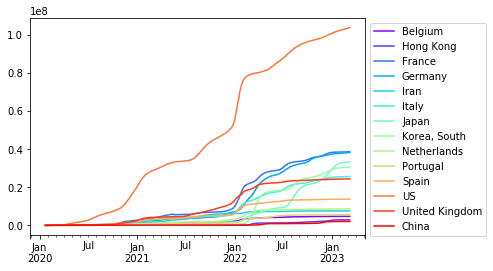

In [20]:
color = cm.rainbow(np.linspace(0, 1, len(interest_countries)))
fig = plt.figure()
ax = fig.add_subplot(111)
df_allCountries_final.plot(ax=ax, color=color)
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

On modifie l'echelle des y en log pour mieux voir les distribution.

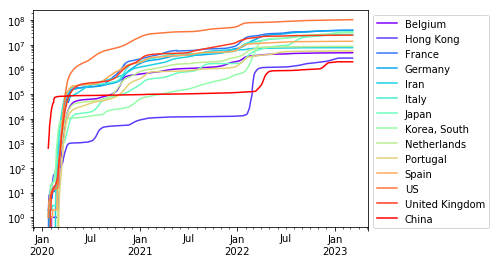

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.yscale("log")   
df_allCountries_final.plot(ax=ax,  color=color)
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

C'est donc les USA ayant eu le plus de cas recences, mais a normaliser par le nombre d'habitant global de chaque territoire et/ou du nombre de deces. 

## Question subsidiaire

On recupere les donnees de deces en faisant une copie local au besoin. 

In [22]:
death_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
death_file = "time_series_covid19_deaths_global.csv"

if not os.path.isfile(death_file):
    urlretrieve(death_url, death_file)    

Comme precedemment, on se doit de regarder les donnees apres chargement.

In [23]:
death_data = pd.read_csv(death_file)
death_data.shape

(289, 1147)

In [24]:
death_data

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
259                                           NaN                  Tuvalu   
260                                           NaN                      US   
261                                           NaN                  Uganda   
262                                           NaN                 Ukraine   
263                                           NaN    United Arab Emirates   
264                                      Anguilla          United Kingdom   
265                                       Bermuda          United Kingdom   
266                        British Virgin Islands          United Kingdom   
267                                Cayman Islands          United Kingdom   
268                               Channel Islands          United Kingdom   
269                   Falkland Islands (Malvinas)          United Kingdom   
270                                     Gibraltar          United Kingdom   
271                                      Guernsey          United Kingdom   
272                                   Isle of Man          United Kingdom   
273                                        Jersey          United Kingdom   
274                                    Montserrat          United Kingdom   
275                              Pitcairn Islands          United Kingdom   
276  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
277                      Turks and Caicos Islands          United Kingdom   
278                                           NaN          United Kingdom   
279                            

Le format est donc identique aux donnees precedentes et peuvent etre traitees de la meme maniere apres les memes verifications
* presence de donnees manquantes 

In [ ]:
columns_to_study =  death_data.iloc[:,4:].columns

for i in raw_data.index :    
    for d in range(len(columns_to_study[:-1])):
        if (pd.isna(death_data.iloc[i,d+4]) or death_data.iloc[i,d+4]<0):
            print(death_data.iloc[i,d+4])

--> pas de donnees manquantes
* incoherence avec un nombre de deces commule qui decroit ?

In [ ]:
flag = 0
for i in death_data.index :  
    for d in range(len(columns_to_study[:-1])):
        if (int(death_data.iloc[i,d+4]) > int(death_data.iloc[i,d+4 +1])):
            data_problem = (death_data.iloc[i, 1:2], columns_to_study[d], columns_to_study[d+1])
            flag = flag +1
print("Il y a %s donnees superieurs a celle de la donnee suivante" % str(flag))

--> on a le meme type d'incoherence que precedemment, minoritaire comparee a la quantite de donnees, mais qu'il faudrait investiguer pour plus de fiabilite dans les donnees. Pour ce TP, je choisis de ne rien filtrer vu la faible proportion que cela represente. 